# Regularization

In practice, many networks we will face in network machine learning will *not* be simple networks. As we discussed in the preceding discussion, many of the techniques we discuss will be just fine to use with weighted networks. Unfortunately, these real world networks are often extremely noisy, and it is for this reason that analysis of one real world network might not generalize very well to a similar real world network. For this reason, we turn to *regularization*. On [wikipedia](#https://en.wikipedia.org/wiki/Regularization_(mathematics)), **regularization** is defined as, "the process of adding information in order to solve an ill-posed problem or to prevent overfitting." In network machine learning, what this usually will entail is modifying the network (or networks) themselves to allow better generalization of our statistical inference to new datasets. For each section, we'll pose an example, a simulation, and code for how to implement the desired regularization approach. But it is important to realize that you might use several of these techniques simultaneously in practice, or you might have reasons to use these techniques that go outside of our working examples.

## Regularization of the Nodes

### Degree trimming removes nodes with low degree

## Regularization of the Edges

### Symmetrizing the network gives us undirectedness

Let's say we have two brain networks from humans and aliens. In this case, we'll say there are six nodes, which are somehow shared across the two life forms. There is one node related to movement, one node related to hearing, one node related to higher-order thinking (like programming!), one node related taste, one node related to smell, and one node related to seeing. The edges $(i, j)$ here will represent the degree to which, if node $i$ is stimulated, node $j$ is stimulated as well. This network is weighted, and the edges take values between $-1$ (if node $i$ is stimulated, node $j$ is definitely *not* stimulated) and $1$ (if node $i$ is stimulated, node $j$ is definitely stimulated). A value of between the two would indicate that if node $i$ is stimulated, node $j$ might (or might not) be stimulated. Our goal is to measure the extent to which the two networks, *ignoring* asymmetries, are similar. Unfortunately, there is one big difference: the human network is *not* symmetric, but the alien network *is* symmetric! What this means is that in humans, node $i$ being stimulated leading to node $j$ does not necessarily mean that node $j$ being stimulated leads to node $i$ being stimulated. To accomplish this goal, we will *symmetrize* the human network. Let's take a look at two example networks. Notice that the human network is not symmetric:

In [26]:
from graspologic.simulations import sbm
from matplotlib import pyplot as plt
from graphbook_code import heatmap
from numpy.random import beta

wtargsh = [[dict(a=8, b=1), dict(a=2, b=10)],
          [dict(a=2, b=2), dict(a=8, b=1)]]

wtargsa = [[dict(lam=10), dict(lam=5)],
          [dict(lam=5), dict(lam=10)]]

# human brain network
Ah = sbm(n=[3,3], p=[[1,1], [1,1]], wt=beta, wtargs=wtargsh, loops=False, directed=True)

# alien brain network
Aa = sbm(n=[3,3], p=[[1, 1], [1, 1]], wt=poisson, wtargs=wtargsa, directed=False)

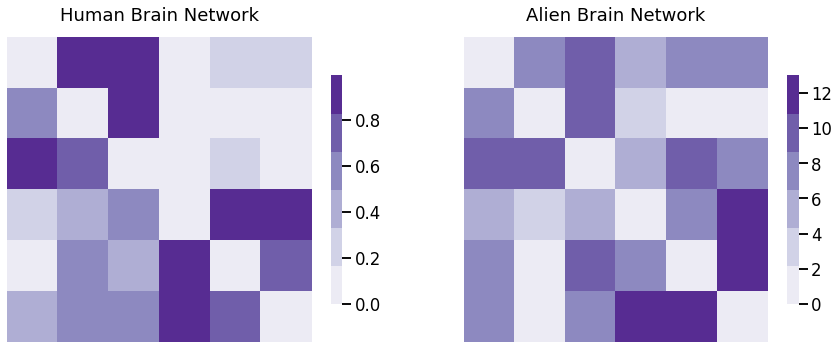

In [27]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(Ah, ax=axs[0], title="Human Brain Network")
heatmap(Aa, ax=axs[1], title="Alien Brain Network")
fig;

Remember that in a symmetric network, $a_{ij} = a_{ji}$, so in an *asymmetric* network, $a_{ij} \neq a_{ji}$. To symmetrize this asymmetric adjacency matrix, what we want is a *new* adjacency value, which we will call $w_{ij}$, which will be a function of $a_{ij}$ and $a_{ji}$. Then, we will construct a new adjacency matrix $A'$, where each entry $a_{ij}'$ *and* $a_{ji}'$ are set equal to $w_{ij}$.  The little apostraphe just signifies that this is a potentially different value than either $a_{ij}$ or $a_{ji}$. Note that by construction, $A'$ is in fact symmetric, becaues $a_{ij}' = a_{ji}'$ due to how we built $A'$. 

#### Ignoring a "triangle* of the adjacency matrix

The easiest way to symmetrize a network $A$ is to just ignore part of it entirely. In the adjacency matrix $A$, you will remember that we have an upper and a lower triangular part of the matrix:
\begin{align*}
    A &= \begin{bmatrix}
        a_{11} & \color{red}{a_{12}} & \color{red}{...} & \color{red}{a_{1n}} \\
        \color{blue}{a_{21}} & \ddots & \color{red}{\ddots} & \color{red}{\vdots} \\
        \color{blue}{\vdots} &\color{blue}{\ddots} &\ddots & \color{red}{a_{n-1, n}}\\
        \color{blue}{a_{n1}} & \color{blue}{...} & \color{blue}{a_{n,n-1}} & a_{nn}
    \end{bmatrix},
\end{align*}
The entries which are listed in <font color="red">red</font> are called the **upper right triangle of the adjacency matrix above the diagonal**. You will notice that for the entries $a_{ij}$ in the upper right triangle of the adjacency matrix, that $a_{ij}$ is such that $j$ is *always* greater than $i$. Similarly, the entries which are listed in <font color="blue">blue</font> are called the **lower left triangle of the adjacency matrix below the diagonal**. In the lower left triangle, $i$ is *always* greater than $j$. These are called *triangles* because of the shape they make when you look at them in matrix form: notice, for instance, that in the upper right triangle, we have a triangle with three corners of values: $a_{12}$, $a_{1n}$, and $a_{n-1, n}$.

So, how do we ignore a triangle all-together? Well, it's really quite simple! We will visually show how to ignore the lower left triangle of the adjacency matrix. We start by forming a triangle matrix, $\Delta$, as follows:
\begin{align*}
    \Delta &= \begin{bmatrix}
        0 & \color{red}{a_{12}} & \color{red}{...} & \color{red}{a_{1n}} \\
        \color{blue}{0} & \ddots & \color{red}{\ddots} & \color{red}{\vdots} \\
        \color{blue}{\vdots} &\color{blue}{\ddots} &\ddots & \color{red}{a_{n-1, n}}\\
        \color{blue}{0} & \color{blue}{...} & \color{blue}{0} & 0
    \end{bmatrix},
\end{align*}
Notice that this matrix *keeps* lal of the upper right triangle of the adjacency matrix above the diagonal the same as in the matrix $A$, but replaces the lower right triangle of the adjacency matrix below the diagonal and the diagonal with $0$s. Notice that the transpose of $\Delta$ is the matrix:
\begin{align*}
    \Delta^\top &= \begin{bmatrix}
        0 & \color{blue}{0} & \color{blue}{...} &\color{blue}{0}\\
        \color{red}{a_{12}}& \ddots & \color{blue}{\ddots} & \color{blue}{\vdots} \\
        \color{red}{\vdots}&\color{red}{\ddots} & \ddots & \color{blue}{0} \\
        \color{red}{a_{1n}}&\color{red}{...} &\color{red}{a_{n-1,n}} & 0
    \end{bmatrix}
\end{align*}
So when we add the two together, we get this:
\begin{align*}
    \Delta + \Delta^\top &= \begin{bmatrix}
        0 & \color{red}{a_{12}} & \color{red}{...} & \color{red}{a_{1n}} \\
        \color{red}{a_{12}} & \ddots & \color{red}{\ddots} & \color{red}{\vdots} \\
        \color{red}{\vdots}&\color{red}{\ddots} &\ddots & \color{red}{a_{n-1, n}}\\
        \color{red}{a_{1n}}&\color{red}{...} &\color{red}{a_{n-1,n}} & 0
    \end{bmatrix},
\end{align*}
We're almost there! We just need to add back the diagonal of $A$, which we will do using the matrix $diag(A)$ which has values $diag(A)_{ii} = a_{ii}$, and $diag(A)_{ij} = 0$ for any $i \neq j$:
\begin{align*}
    A' &= \Delta + \Delta^\top + diag(A) = \begin{bmatrix}
        a_{11} & \color{red}{a_{12}} & \color{red}{...} & \color{red}{a_{1n}} \\
        \color{red}{a_{12}} & \ddots & \color{red}{\ddots} & \color{red}{\vdots} \\
        \color{red}{\vdots}&\color{red}{\ddots} &\ddots & \color{red}{a_{n-1, n}}\\
        \color{red}{a_{1n}}&\color{red}{...} &\color{red}{a_{n-1,n}} & a_{nn}
    \end{bmatrix},
\end{align*}
Which leaves $A'$ to be a matrix consisting *only* of entries which were in the upper right triangle of $A$. $A'$ is obviously symmetric, because $a_{ij}' = a_{ji}'$ for all $i$ and $j$. Since the adjacency matrix is symmetric, the network $A'$ represents is therefore undirected. In graspologic, we can implement this as follows:

In [41]:
from graspologic.utils import symmetrize

# symmetrize with upper right triangle
Ah_upright_sym = symmetrize(Ah, method="triu")

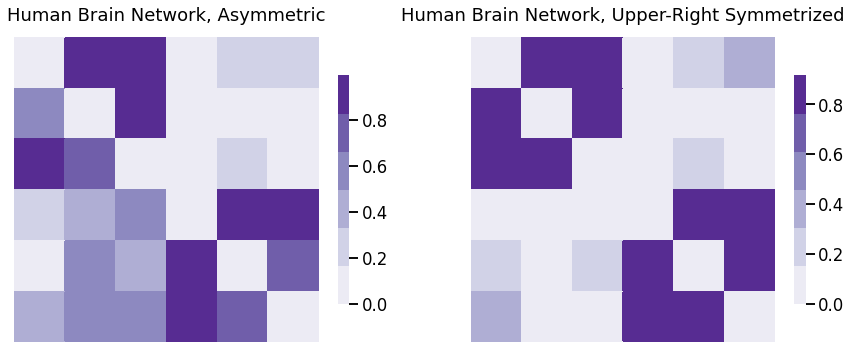

In [42]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(Ah, ax=axs[0], title="Human Brain Network, Asymmetric")
heatmap(Ah_upright_sym, ax=axs[1], title="Human Brain Network, Upper-Right Symmetrized")
fig;

Likewise, we can lower-left symmetrize as well:

In [43]:
# symmetrize with lower left triangle
Ah_lowleft_sym = symmetrize(Ah, method="tril")

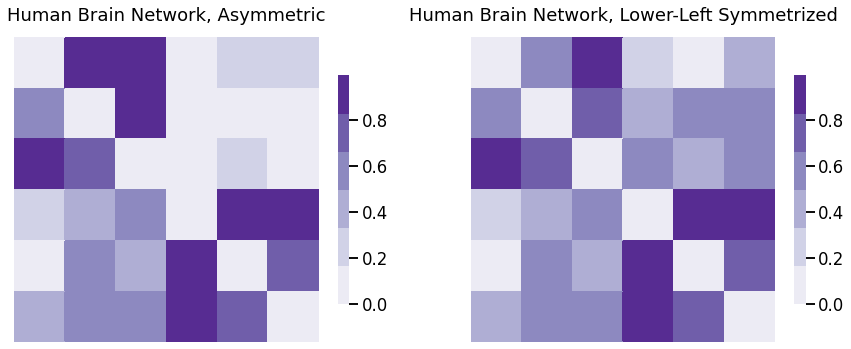

In [44]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(Ah, ax=axs[0], title="Human Brain Network, Asymmetric")
heatmap(Ah_lowleft_sym, ax=axs[1], title="Human Brain Network, Lower-Left Symmetrized")
fig;

#### Taking a function of the two values

There are many ways we can also take a function of $a_{ij}$ and $a_{ji}$ to end up with a symmetric matrix. One such is we can just average the two. That is, we can let the matrix $A'$ be the matrix with entries $a'_{ij} = \frac{a_{ij} + a_{ji}}{2}$ for all $i$ and $j$. In matrix form, this operation looks like this:

\begin{align*}
    A' &= \frac{1}{2} (A + A^\top) \\
    &= \frac{1}{2}\left(\begin{bmatrix}
        a_{11} & ... & a_{1n} \\
        \vdots & \ddots & \vdots \\
        a_{n1} & ... & a_{nn}
    \end{bmatrix} + \begin{bmatrix}
        a_{11} & ... & a_{n1} \\
        \vdots & \ddots & \vdots \\
        a_{1n} & ... & a_{nn}
    \end{bmatrix}\right)\\
    &= \begin{bmatrix}
        \frac{1}{2}(a_{11} + a_{11}) & ... & \frac{1}{2}(a_{1n} + a_{n1}) \\
        \vdots & \ddots & \vdots \\
        \frac{1}{2} (a_{n1} + a_{1n}) & ... & \frac{1}{2}(a_{nn} + a_{nn})
    \end{bmatrix} \\
    &= \begin{bmatrix}
        a_{11} & ... & \frac{1}{2}(a_{1n} + a_{n1}) \\
        \vdots & \ddots & \vdots \\
        \frac{1}{2} (a_{n1} + a_{1n}) & ... & a_{nn}
    \end{bmatrix}
\end{align*}
As we can see, for all of the entries, $a'_{ij} = \frac{1}{2} (a_{ij} + a_{ji})$, and also $a_{ji}' = \frac{1}{2}(a_{ji} + a_{ij})$. These quantities are the same, so $a_{ij}' = a_{ji}'$, and $A'$ is symmetric. As the adjacency matrix is symmetric, the network thta $A'$ represents is undirected. We can implement this in graspologic as follows:

In [45]:
# symmetrize with averaging
Ah_avg_sym = symmetrize(Ah, method="avg")

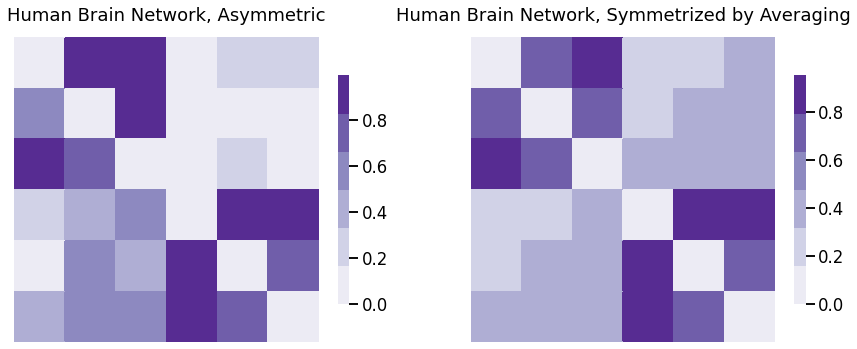

In [47]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

heatmap(Ah, ax=axs[0], title="Human Brain Network, Asymmetric")
heatmap(Ah_avg_sym, ax=axs[1], title="Human Brain Network, Symmetrized by Averaging")
fig;

### Thresholding converts weighted networks to binary networks

### Sparsification removes potentially spurious low-weight edges

### Diagonal augmentation

https://github.com/microsoft/graspologic/blob/f9c4353488e29d367dec62fdb4729e6a7344fd89/graspologic/embed/ase.py#L58

### Z-scoring standardizes edge weights using the normal distribution

### Logging reduces magnitudinal differences between edges

### Ranking edges preserves only ordinal relationships